### Libary Import setting and Loading the data 

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings

rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision' , 4)
warnings.simplefilter('ignore')

In [2]:
data_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\data\astronomical-object')
feature_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\feature')
sub_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\sub')
val_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\val')
tst_dir = Path(r'C:\Users\789\Desktop\github_local\Machine Learning\clean-fix\build\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'train.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'type'
n_fold = 5
n_class = 19
seed = 42

In [3]:
algo_name = 'rfcv' #random forest cross validation
feature_name = 'feature' # non polynomial
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv' # 이 피쳐 파일 사용
p_val_file = val_dir / f'{model_name}.val.csv' # 나중에 to_csv로 출력 이 변수에
p_tst_file = tst_dir / f'{model_name}.tst.csv' # 나중에 to_csv로 출력 이 변수에
sub_file = sub_dir / f'{model_name}.csv' # 단일 모델 제출용

df = pd.read_csv(feature_file, index_col = 0)
print(df.shape)
df.head()


(210000, 21)


,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,
0,QSO,6.4003,23.1982,21.4320,21.3141,21.1766,21.1714,21.6445,21.6576,21.3877,21.5728,22.5043,21.4316,21.4783,21.1454,20.4224,22.7492,21.4655,21.3642,21.0206,21.1473
1,QSO,6.6708,21.4314,20.7081,20.6789,20.7034,20.4732,21.0298,20.9671,20.9377,21.0636,21.3607,20.7790,20.8897,20.6398,20.6467,21.4930,20.7585,20.7539,20.6934,20.5123
2,QSO,6.0591,17.8515,16.7279,16.6797,16.6946,16.6418,17.0331,16.9997,17.0960,17.0764,17.8673,16.7388,16.6889,16.7442,16.8080,17.8181,16.6974,16.6412,16.6602,16.6889
3,QSO,6.7627,20.7899,20.0404,19.9269,19.8438,19.4633,20.3172,20.2179,20.0739,19.7945,20.4339,19.9937,19.9855,19.7509,19.4551,20.7707,20.0017,19.8898,19.7581,19.5529
4,STAR_RED_DWARF,6.4184,26.4550,23.0588,21.4714,19.5050,18.3891,23.6291,21.7428,19.8617,18.8104,25.8592,22.4269,21.6736,19.6100,18.3761,24.8771,23.1480,21.4753,19.4873,18.3757


1. p_val_file : Validation set에서 얻은 예측 확률값 out of fold prediction 저장용. 스태킹에서 레벨 2 모델의 학습 데이터로 사용됨. 교차검증동안, 각 폴드에서 밸리데이션 데이터를 예측한 확률값을 모은 것.
모델의 generalization 성능을 분석하는 데도 사용됨

2. p_tst_file : test set에 대한 예측 확률값. 
 - 최종적으로 submission 파일을 만들기 위한 전처리용으로 사용되거나
 - 여러 모델 예측 결과를 평균하는 앙상블 계산으로도 활용

3. sub_file : 대회 등에 제출할 최종 submission 파일 저장 경로

In [4]:
y = df[target_col].values[:199991] #벡터화 후, 트레이닝셋까지 범위 슬라이싱
df.drop(target_col, axis = 1, inplace = True)
trn = df.iloc[:199991].values 
tst = df.iloc[199991:].values
feature_name = df.columns.tolist() # 리스트 반환
print(y.shape, trn.shape, tst.shape)

(199991,) (199991, 20) (10009, 20)


In [5]:
# Startified K-Fold Cross Validation

cv = StratifiedKFold(n_splits=n_fold, shuffle= True, random_state=seed)

In [6]:
# Train Random forest

p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
  # enumerate의 맨 마지막 인자 1은, 인덱스 시작점을 설정
  # 1부터 시작
  # 여기에서 i_trn과 i_val은 샘플의 인덱스를 반환함.
  # [132, 15647, 12314, 4655...] 이런 식으로.
  print(f'training model for CV #{i}')
  clf = RandomForestClassifier(n_estimators=100,
                               min_samples_leaf=10,
                               max_features='sqrt',
                               max_samples=.5,
                               random_state = seed,
                               n_jobs = -1)
  clf.fit(trn[i_trn], y[i_trn])
  p_val[i_val,:] = clf.predict_proba(trn[i_val])
  p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f'{accuracy_score(y_encoded, np.argmax(p_val, axis=1))*100:.4f}%') 

# argmax는, axis = 1일 때, 각 로우의 요소들 중, 가장 값이 높은 요소의 "인덱스"를 반환함

86.8684%


In [8]:
print(p_val.shape, p_tst.shape)

# 합 210000개로 딱 맞음

(199991, 19) (10009, 19)


<Axes: ylabel='feature'>

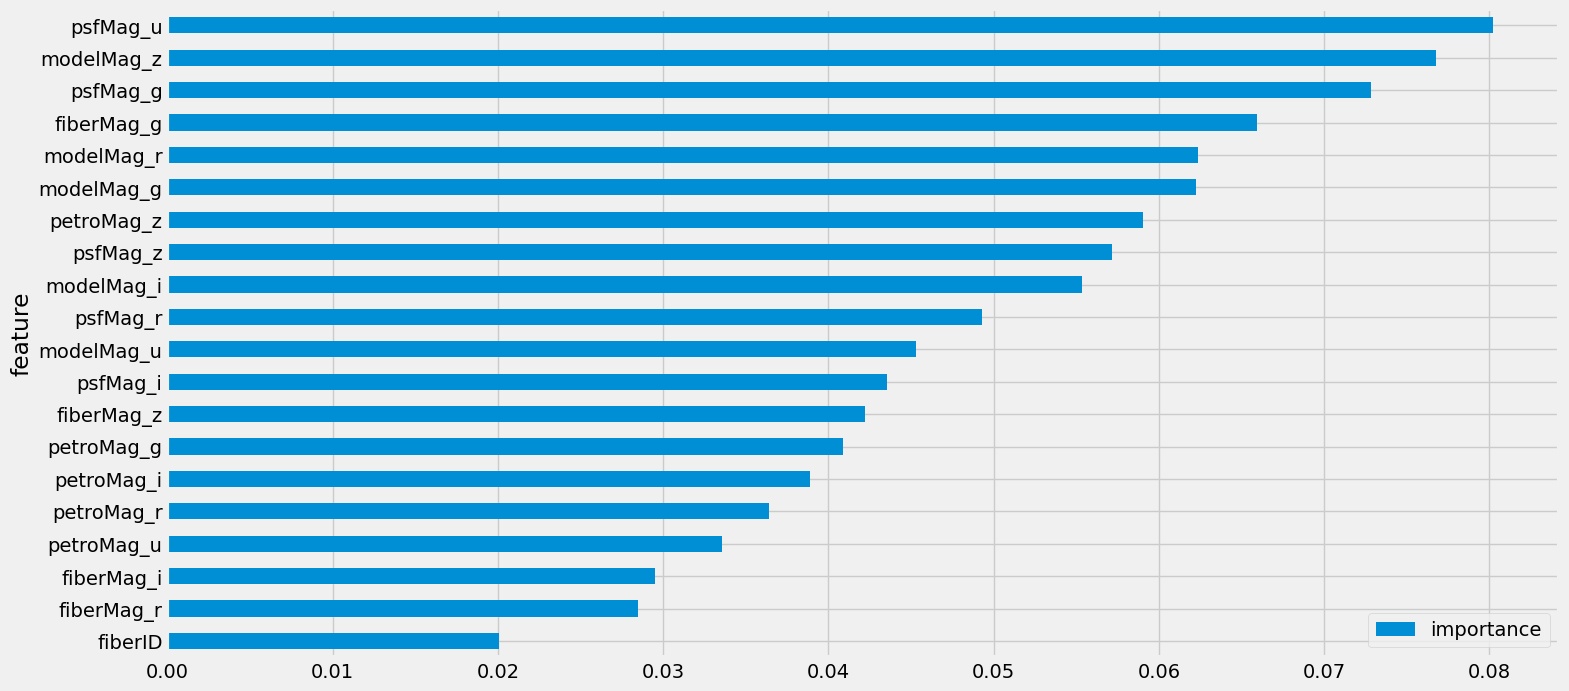

In [9]:
# 피쳐 중요도 시각화

imp = pd.DataFrame({'feature':df.columns, 'importance':clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [10]:
# submission

sub = pd.read_csv(sample_file, index_col = 0)
print(sub.shape)
sub.head()

(10009, 19)


,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
sub_col = sub.columns.tolist()
sub[sub_col] = p_tst

In [12]:
print(clf.classes_)

['GALAXY' 'QSO' 'REDDEN_STD' 'ROSAT_D' 'SERENDIPITY_BLUE'
 'SERENDIPITY_DISTANT' 'SERENDIPITY_FIRST' 'SERENDIPITY_MANUAL'
 'SERENDIPITY_RED' 'SKY' 'SPECTROPHOTO_STD' 'STAR_BHB' 'STAR_BROWN_DWARF'
 'STAR_CARBON' 'STAR_CATY_VAR' 'STAR_PN' 'STAR_RED_DWARF' 'STAR_SUB_DWARF'
 'STAR_WHITE_DWARF']


In [13]:
# clf.classes_ 기준 열 순서 -> sub.columns 기준 열 순서로 인덱스 찾기
idx = [list(clf.classes_).index(col) for col in sub_col]

# p_tst 배열의 열을 정렬
p_tst_ordered = p_tst[:, idx]

# 재정렬된 확률을 넣기
sub[sub.columns] = p_tst_ordered


new commit markdown

In [14]:
sub.head()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
id,,,,,,,,,,,,,,,,,,,
199991,0.0000,0.0000e+00,0.0015,0.1205,0.0003,0.0003,0.0004,0.0000,0.0020,0.0,0.8707,0.0018,0.0,1.9048e-04,0.0000,0.0,0.0000,2.0626e-03,0.0003
199992,0.0000,0.0000e+00,0.0000,0.0000,0.0000,0.0002,0.0109,0.0012,0.4691,0.0,0.0002,0.3127,0.0,2.0445e-01,0.0002,0.0,0.0000,8.6957e-05,0.0009
199993,0.0000,5.0000e-04,0.0000,0.0000,0.0006,0.0000,0.9890,0.0000,0.0021,0.0,0.0000,0.0069,0.0,8.6957e-05,0.0007,0.0,0.0001,0.0000e+00,0.0000
199994,0.0003,6.4516e-05,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.1186,0.0,0.0000,0.0224,0.0,3.3111e-02,0.0000,0.0,0.0000,0.0000e+00,0.8146
199995,0.0000,0.0000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.9982,0.0018,0.0,0.0000e+00,0.0000,0.0,0.0000,0.0000e+00,0.0000


In [15]:
sub.to_csv(sub_file)